## `YOLO for detector`

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import torch
from PIL import Image
from ultralytics import YOLO

In [4]:
model = YOLO("YOLO/model_28_10.pt")

In [3]:
def check_current_place(class_indexes):
    count = 0
    for class_index in class_indexes:
        if class_index == 0:
            count += 1

    if count > 2:
        return False
    return True

In [5]:
class_colors = {
    "current_places": (255,0,0),
    "dob": (0,255,0),
    "expire_date": (0,0,255),
    "gender": (255,255,0),
    "id": (255,0,255),
    "name":(0,255,255),
    "nationality": (255, 128, 0),
    "origin_place": (0,0,0)
}

In [11]:
def word_detection(img_path):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    predict = model(img)
    
    class_indexes = predict[0].boxes.cls.numpy()
    if check_current_place(class_indexes) == False:
        return None
    class_names = [model.names[int(class_index)] for class_index in class_indexes]
    scores = predict[0].boxes.conf.numpy()
    boxes = predict[0].boxes.xyxy.numpy()
    
    for i, class_name in enumerate(class_names):
        x1, y1, x2, y2 = boxes[i]
        color = class_colors.get(class_name)
        img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color = color, thickness=2)
        
    return img


0: 416x640 2 current_places, 1 dob, 2 expire_dates, 1 gender, 1 id, 1 name, 1 nationality, 1 origin_place, 270.0ms
Speed: 37.5ms preprocess, 270.0ms inference, 24.8ms postprocess per image at shape (1, 3, 416, 640)


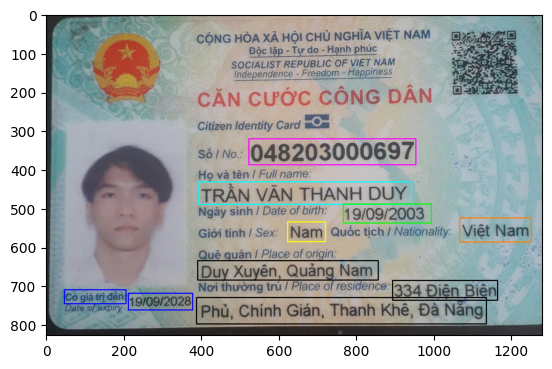

In [24]:
path = 'cccd.jpg'
result = word_detection(path)
plt.imshow(result);

## `Recognition by VietOCR`

In [3]:
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

config = Cfg.load_config_from_name('vgg_transformer')
config["weights"] = "vietocr_weight.pth"
config['cnn']['pretrained'] = False
config['device'] = 'cpu' # mps

recognitor = Predictor(config)

c:\Users\ADMIN\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [8]:
def predict(recognitor, model, img_path, save_path, padding=4, dpi=100):
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    # Dự đoán các vùng chứa chữ trên ảnh
    predict = model(img)
    class_indexes = predict[0].boxes.cls.numpy()
    
    
    class_names = [model.names[int(class_index)] for class_index in class_indexes]
    scores = predict[0].boxes.conf.numpy()
    boxes = predict[0].boxes.xyxy.numpy()
    # Tạo danh sách các box (với padding)
    for box in boxes:
        box[0] = box[0] - padding
        box[1] = box[1] - padding
        box[2] = box[2] + padding
        box[3] = box[3] + padding
    texts = []
    for i, box in enumerate(boxes):
        x1, y1, x2, y2 = box
        color = class_colors.get(class_names[i], (255, 255, 255))  # Mặc định là màu trắng nếu không có màu
        # Cắt vùng chứa chữ từ bounding box
        cropped_img = img[int(y1):int(y2), int(x1):int(x2)]
        # Chuyển đổi ảnh sang định dạng phù hợp với VietOCR
        cropped_img_rgb = Image.fromarray(cropped_img)
        # Nhận diện chữ với VietOCR
        text = recognitor.predict(cropped_img_rgb)
        texts.append(text)
        # Vẽ bounding box và text lên ảnh
        img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), color=color, thickness=2)
        cv2.putText(img, text, (int(x1), int(y1) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    # Lưu ảnh kết quả
    img_name = img_path.split('/')[-1]
    cv2.imwrite(os.path.join(save_path, img_name), img)
    # Hiển thị ảnh kết quả
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    height, width, depth = img.shape
    figsize = width / float(dpi), height / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.axis('off')
    ax.imshow(img, cmap='gray')

    plt.show()
    return boxes, texts


0: 640x640 2 current_places, 1 dob, 1 expire_date, 1 gender, 1 id, 1 name, 1 nationality, 1 origin_place, 169.1ms
Speed: 3.9ms preprocess, 169.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


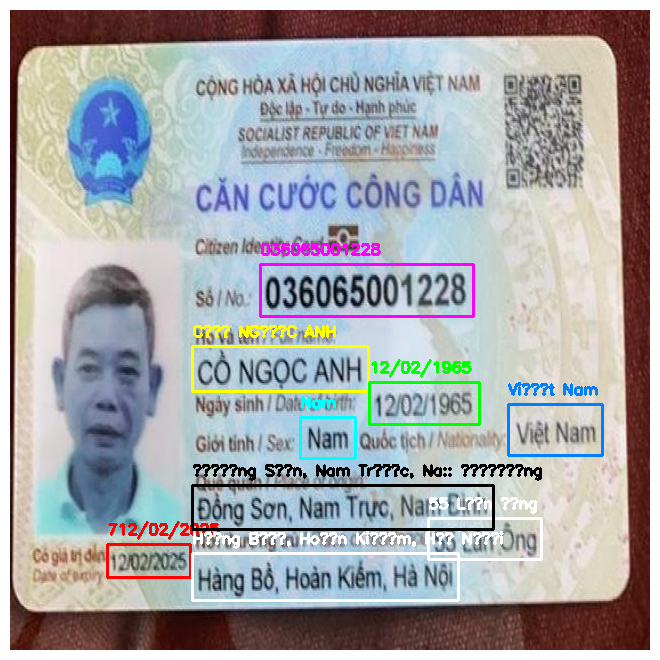

In [9]:
input_path = 'images/image5.jpg'
output_path = './output'
boxes, texts = predict(recognitor, model, input_path, output_path, padding=2, dpi=100)

In [10]:
texts

['036065001228',
 '55 Lân Ông',
 'CỒ NGỌC ANH',
 '712/02/2025',
 'Hàng Bồ, Hoàn Kiếm, Hà Nội',
 'Đồng Sơn, Nam Trực, Na:: Đường',
 'Việt Nam',
 '12/02/1965',
 'Nam']